## Разведовательный анализ данных и линейная регрессия.
Предсказание времени поездки такси в Нью-Йорке

In [2]:
%pylab inline
!pip install folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline


sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


**Данные** взяты из соревнования New York City Taxi Trip Duration:

https://www.kaggle.com/c/nyc-taxi-trip-duration/overview

В нем требуется предсказать длительность поездки на такси.

"In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables"

In [559]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head(5)

(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [560]:
data = data.drop(columns=["dropoff_datetime"])
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


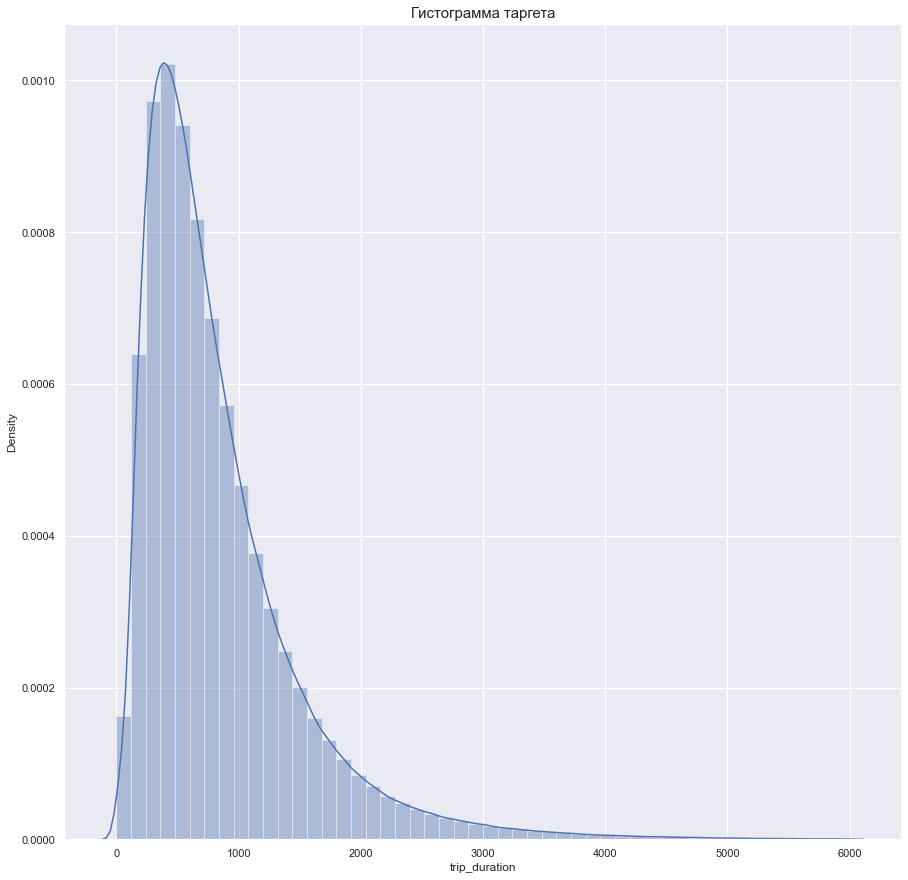

In [562]:
sns.distplot(data[data['trip_duration'] < 6000]['trip_duration'])
plt.title("Гистограмма таргета", fontsize=15)
plt.rcParams['figure.figsize'] = 15, 15
plt.show()

В целевой переменной есть очень большие значения-выбросы. 

При увеличении времени поездки, большее, чем примерно 700 секунд количество поездок убывает.

В соревновании на Kaggle используется RMSLE.


У нашей целевой переменной очень много выбросов, а при использовании RMSLE их негативное влияние уменьшается.
Но при маленьких значения штраф увеличивается, а это нам выгодно.

Приведем наши данные при помощи логарфима для MSE:

$$MSE(\hat{a}, X) = \frac{1}{\ell}\sum\limits_{i = 1}^{\ell}(\hat{a}(x_i) - \hat{y_i})^2$$

Подставим $a(x_i) = \exp(\hat{a}(x_i)) - 1$,  $y_i = \exp(\hat{y}_i) - 1$ в формулу RMSLE:
$$ \text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(exp(\hat{y}_i) - 1 + 1)} - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(exp(\hat{y}_i))} - \log{(\exp(\hat{a}(x_i)))}\big)^2} = $$
$$=\sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \hat{a}(x_i)\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{a}(x_i) - \hat{y}_i\big)^2}$$

Мы получили, что для RMSLE и MSE оптимизация эквивалентна.


C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


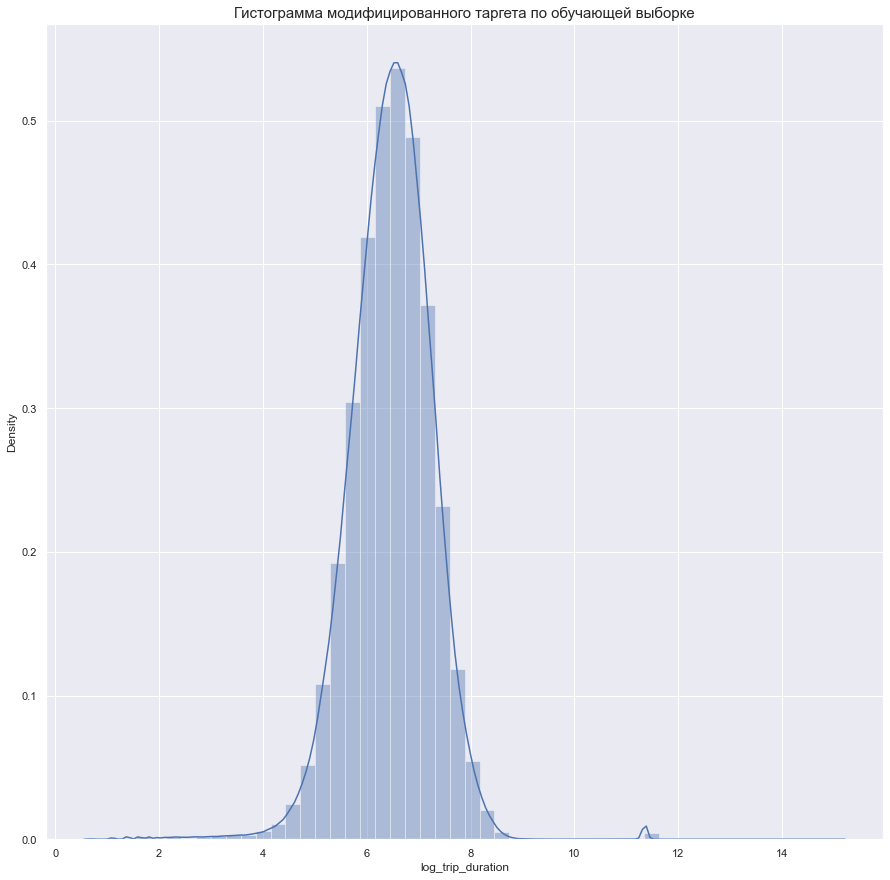

In [563]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])
data = data.drop(columns=['trip_duration'])
sns.distplot(data['log_trip_duration'])
plt.rcParams['figure.figsize'] = 10, 10
plt.title("Гистограмма модифицированного таргета по обучающей выборке", fontsize=15)
plt.show()

Значение метрики при наилучшем константном предсказании:

In [564]:
from sklearn.metrics import mean_squared_error
best_constant = data['log_trip_duration'].mean()
er = mean_squared_error(data['log_trip_duration'], best_constant * np.ones(data['log_trip_duration'].shape),
                                                                 squared=False)
print("RMSE при наилучшем константном предсказании = %.4f" % er)

RMSE при наилучшем константном предсказании = 0.7958


## Рассмотрим данные, связанные со временем поездки:

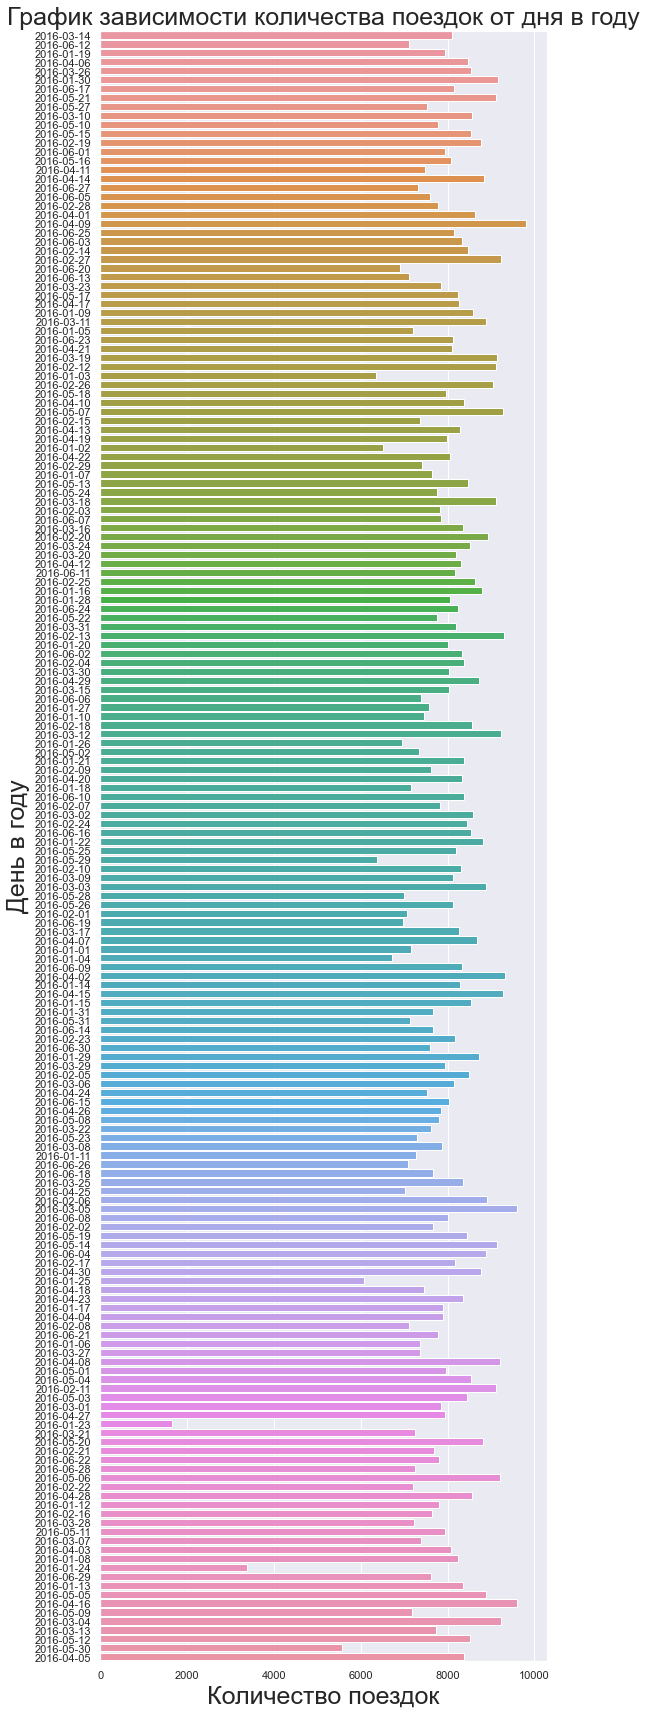

In [13]:
fig  = sns.countplot(y = data['pickup_datetime'].dt.date)
plt.ylabel("День в году", fontsize=25)
plt.xlabel("Количество поездок", fontsize=25)
plt.title("График зависимости количества поездок от дня в году", fontsize=25)
plt.rcParams['figure.figsize'] = 8, 30
sns.set_palette("pastel")
plt.show()

In [565]:
print('2 периода с аномально маленькими количествами поездок:')
data['pickup_datetime'].dt.date.value_counts().sort_values().reset_index().iloc[0:2]['index']

2 периода с аномально маленькими количествами поездок:


0    2016-01-23
1    2016-01-24
Name: index, dtype: object

В Нью-Йорке введен запрет на использование дорог, туннелей и мостов в связи с сильнейшим снегопадом за столетие в эти 2 периода.

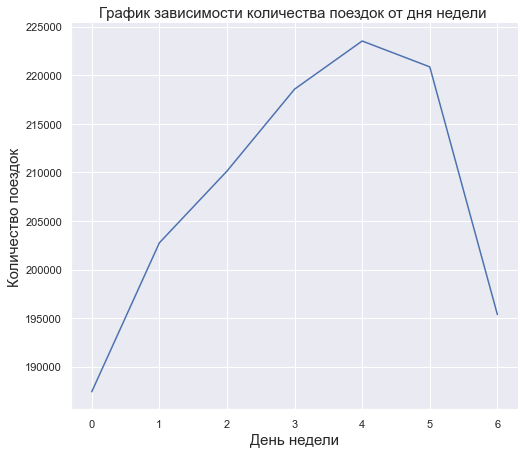

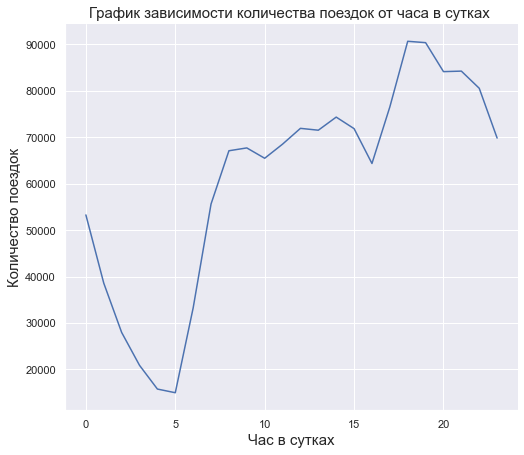

In [480]:
data2 = (data['pickup_datetime'].dt.dayofweek).value_counts().reset_index()
data3 = (data['pickup_datetime'].dt.hour).value_counts().reset_index()
sns.relplot(x=data2['index'], y=data2['pickup_datetime'],
            height=6, aspect = 1.2, kind='line')
plt.xlabel("День недели", fontsize=15)
plt.ylabel("Количество поездок", fontsize=15)
plt.title("График зависимости количества поездок от дня недели ", fontsize=15)
sns.relplot(x=data3['index'], y=data3['pickup_datetime'],  height=6, aspect = 1.2, kind='line')
plt.xlabel("Час в сутках", fontsize=15)
plt.ylabel("Количество поездок", fontsize=15)
plt.title("График зависимости количества поездок от часа в сутках ", fontsize=15)
plt.show()

In [566]:
datahelpmonth = data[['pickup_datetime']]
datahelpmonth['hour'] = datahelpmonth['pickup_datetime'].dt.hour
datahelpmonth['month'] = datahelpmonth['pickup_datetime'].dt.month_name()
datahelpmonth = datahelpmonth.groupby(by=['month', 'hour']).size().reset_index(name='count')
datahelpweek = data[['pickup_datetime']]
datahelpweek['hour'] = datahelpweek['pickup_datetime'].dt.hour
datahelpweek['day_of_week'] = datahelpweek['pickup_datetime'].dt.dayofweek
datahelpweek = datahelpweek.groupby(by=['day_of_week', 'hour']).size().reset_index(name='count')

<ipython-input-566-70c2a3d8a1d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datahelpmonth['hour'] = datahelpmonth['pickup_datetime'].dt.hour
<ipython-input-566-70c2a3d8a1d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datahelpmonth['month'] = datahelpmonth['pickup_datetime'].dt.month_name()
<ipython-input-566-70c2a3d8a1d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

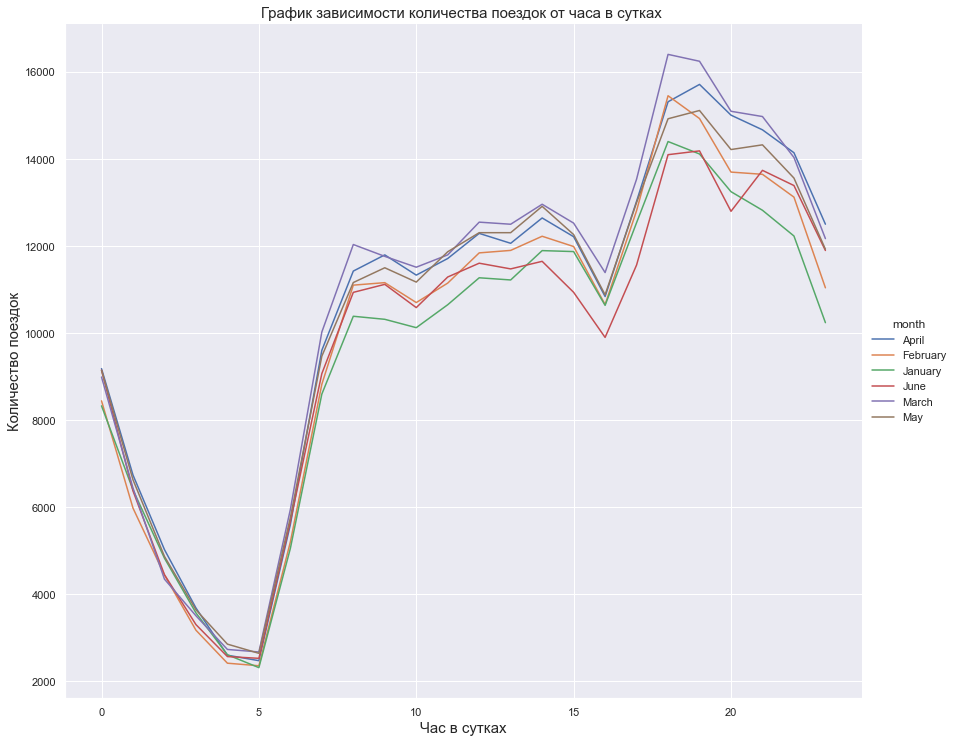

In [567]:
sns.relplot(x=datahelpmonth['hour'],
            y=datahelpmonth['count'],
            height=10, aspect = 1.2, kind='line', hue = datahelpmonth['month'])
plt.xlabel("Час в сутках", fontsize=15)
plt.ylabel("Количество поездок", fontsize=15)
plt.title("График зависимости количества поездок от часа в сутках ", fontsize=15)
plt.show()

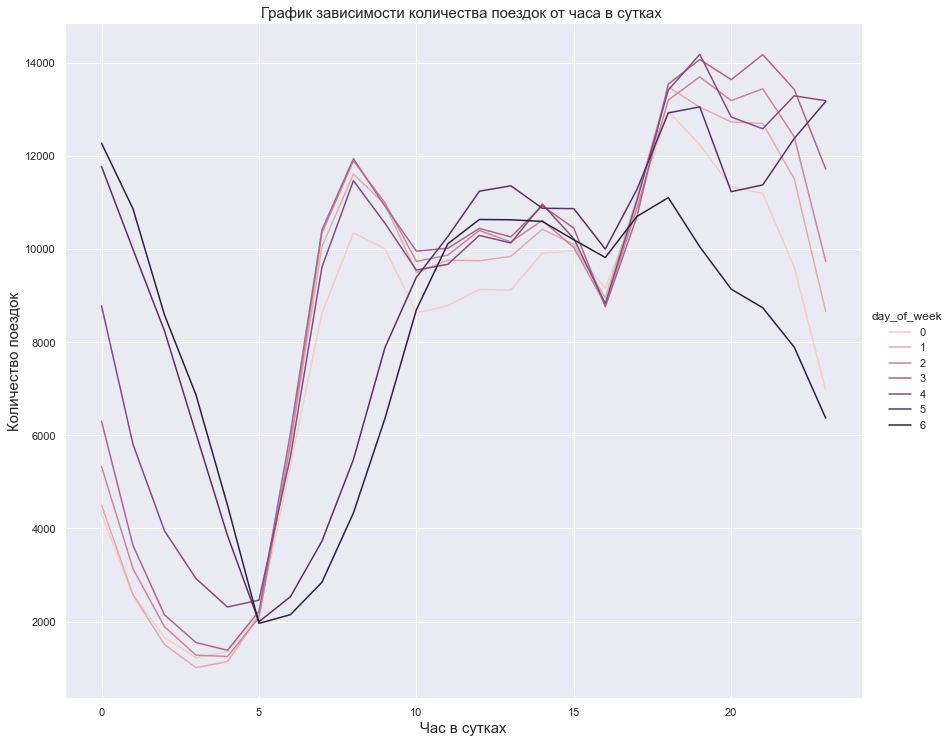

In [483]:
sns.relplot(x=datahelpweek['hour'],
            y=datahelpweek['count'],
            height=10, aspect = 1.2, kind='line', hue = datahelpweek['day_of_week'])
plt.xlabel("Час в сутках", fontsize=15)
plt.ylabel("Количество поездок", fontsize=15)
plt.title("График зависимости количества поездок от часа в сутках ", fontsize=15)
plt.show()

С понедельника по четверг возрастает количество поездок, а в воскресенье снова снижается. Самые пики в пятницу и субботу, в силу выходных дней и соответсвующей ночной жизни на уик-энде.

В месяцах большой разницы нет, можно только выделить, что в весенний период пассажиры более активны.

Максимальная активность приходится на период часов с 17 до 24 в силу конца рабочего дня или началу ночных вечеринок.
Минимальная же активность проявляется на раннее утро примерно в 5 часов.


In [568]:
from sklearn.model_selection import train_test_split
y = data["log_trip_duration"]
X = data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

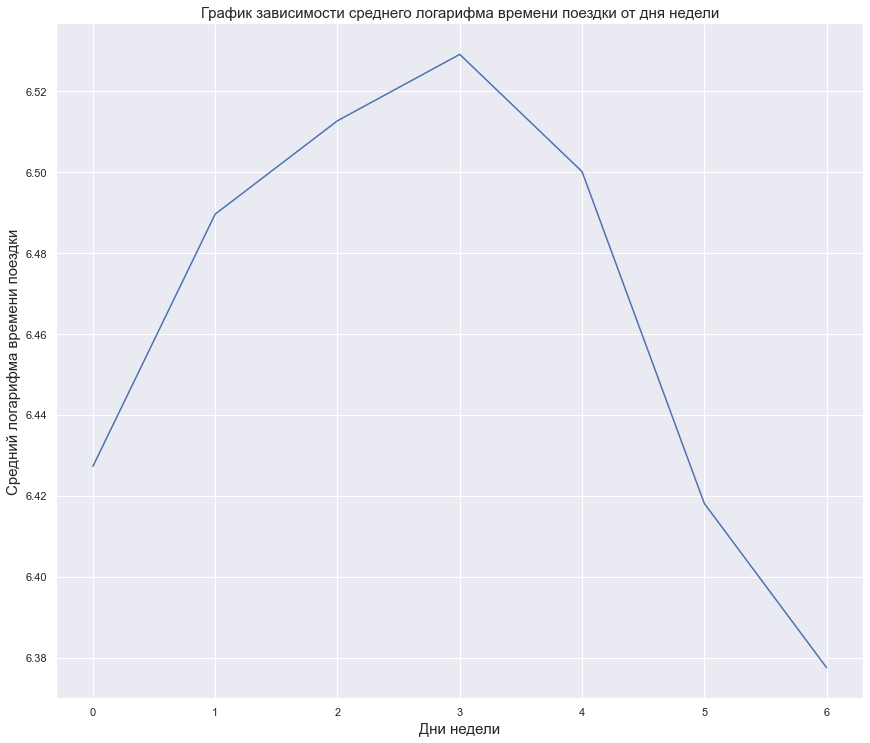

In [569]:
sns.relplot(x = data.groupby(by=X_train['pickup_datetime'].dt.dayofweek).mean().reset_index()['pickup_datetime'],
                 y = data.groupby(by=X_train['pickup_datetime'].dt.dayofweek).mean().reset_index()['log_trip_duration'],
           kind='line',height=10, aspect = 1.2)
plt.xlabel("Дни недели", fontsize=15)
plt.ylabel("Средний логарифма времени поездки", fontsize=15)
plt.title("График зависимости среднего логарифма времени поездки от дня недели", fontsize=15)
sns.set_palette("pastel")
plt.show()

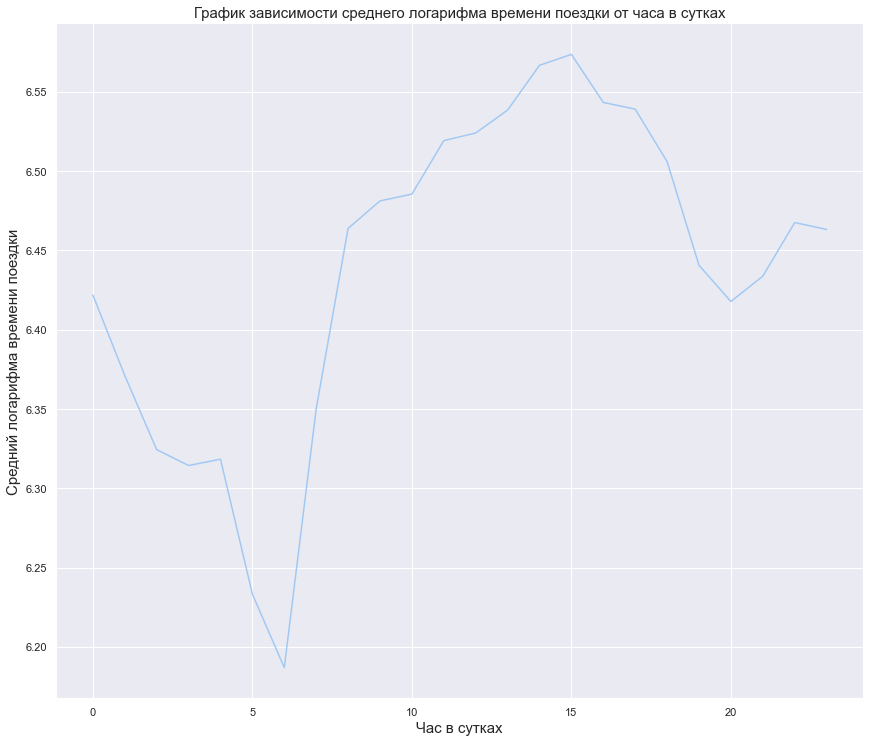

In [266]:
sns.relplot(x = data.groupby(by=X_train['pickup_datetime'].dt.hour).mean().reset_index()['pickup_datetime'],
                 y = data.groupby(by=X_train['pickup_datetime'].dt.hour).mean().reset_index()['log_trip_duration'],
            kind='line',height=10, aspect = 1.2)
plt.xlabel("Час в сутках", fontsize=15)
plt.ylabel("Средний логарифма времени поездки", fontsize=15)
plt.title("График зависимости среднего логарифма времени поездки от часа в сутках", fontsize=15)

plt.show()

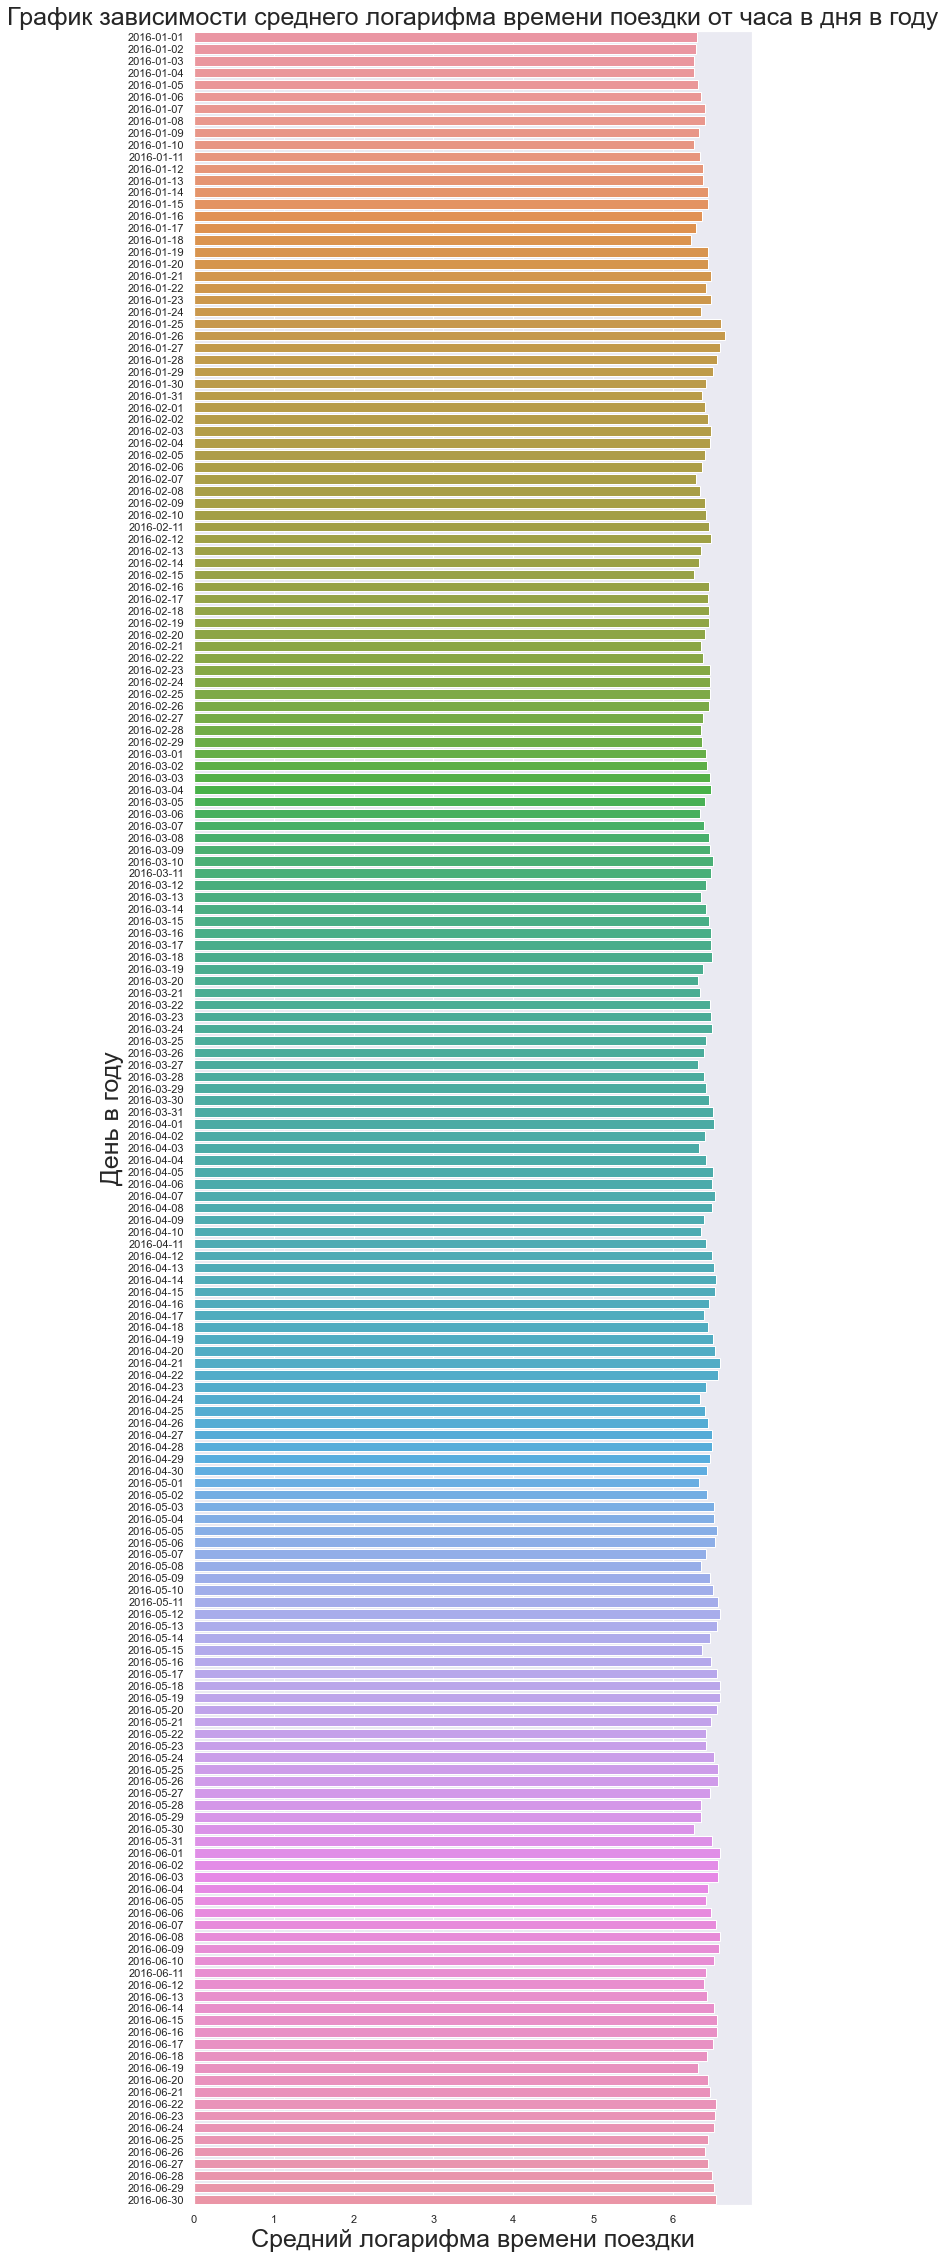

In [621]:
fig = sns.barplot(y = data.groupby(by=X_train['pickup_datetime'].dt.date).mean().reset_index()['pickup_datetime'],
                 x = data.groupby(by=X_train['pickup_datetime'].dt.date).mean().reset_index()['log_trip_duration'])
plt.ylabel("День в году", fontsize=25)
plt.xlabel("Средний логарифма времени поездки", fontsize=25)
plt.title("График зависимости среднего логарифма времени поездки от часа в дня в году", fontsize=25)
plt.rcParams['figure.figsize'] = 10, 40
plt.show()

Графики зависимости таргета от дня недели и от часа в сутках сильно схожи с аналогичными графиками для количества поездок, так как в периоды большой активности происходит больше поездок, то есть и больше продолжительных поездок в частности.
Также в периоды большой активности больше машин на дорогах, то есть движение затруднено и люди стоят дольше в пробках.

На графике зависимости log_trip_duration от номера дня в году можно заметить некий гармонический тренд.


In [570]:
def new_datetime(data):
    data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
    data['month'] = data['pickup_datetime'].dt.month_name()
    data['hour'] = data['pickup_datetime'].dt.hour
    data['anomalous1'] = [0] * data.shape[0]
    data.loc[list((data[data['pickup_datetime'].dt.date == data['pickup_datetime'].dt.date.value_counts().sort_values().index[0]]).index), 'anomalous1'] = 1
    data['anomalous2'] = [0] * data.shape[0]
    data.loc[list((data[data['pickup_datetime'].dt.date == data['pickup_datetime'].dt.date.value_counts().sort_values().index[1]]).index), 'anomalous2'] = 1
    data['day_number'] = data['pickup_datetime'].dt.dayofyear
    
new_datetime(data)
new_datetime(X_test)
new_datetime(X_train)  

<ipython-input-570-d95c5a1b774c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
<ipython-input-570-d95c5a1b774c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month'] = data['pickup_datetime'].dt.month_name()
<ipython-input-570-d95c5a1b774c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Категориальными будут: День недели, Месяц, Час, Номер дня в году. Несмотря на то что признаки Часа и Номера дня в году представлены числами они являются "названиями". Например мы не можем сказать, что 2 часа ночи слабее, чем 18 часов вечера.

Также есть два бинарных признака, соответствующие двум аномальным периодам.

In [571]:
categorical1 = ['day_of_week', 'month', 'hour', 'day_number']
numeric_features = ['anomalous1', 'anomalous2']
feat = numeric_features + categorical1

In [572]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model = pipeline.fit(X_train[feat], y_train)
y_pred = model.predict(X_test[feat])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7865


## Посмотрим, что происходит с координатами:

Можем выделить два Аэропорта, которые находятся в неком отдалении от Манхэтана.

In [573]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

data['haversine'] = haversine_array(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])


In [574]:
data['log_haversine'] = np.log1p(data['haversine'])

In [575]:
print('Корреляция логарифма расстояния с нашим таргетом:')
print(data['log_trip_duration'].corr(data['log_haversine']))
print('Корреляция расстояния с нашим таргетом:')
print(data['log_trip_duration'].corr(data['haversine']))

Корреляция логарифма расстояния с нашим таргетом:
0.7498822373942503
Корреляция расстояния с нашим таргетом:
0.5735948311180166


In [576]:
data['speed'] = data['haversine'] / ((np.exp(data['log_trip_duration']) - 1) / 3600)

C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


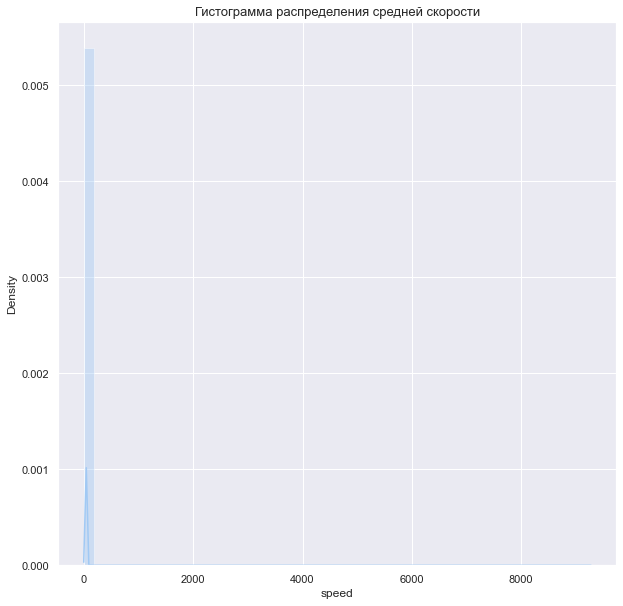

In [496]:
sns.distplot(data['speed']).set_title('Гистограмма распределения средней скорости', fontsize=13)
plt.rcParams['figure.figsize'] = 7, 7
plt.show()

C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Гистограмма распределения средней скорости для разумных значений')

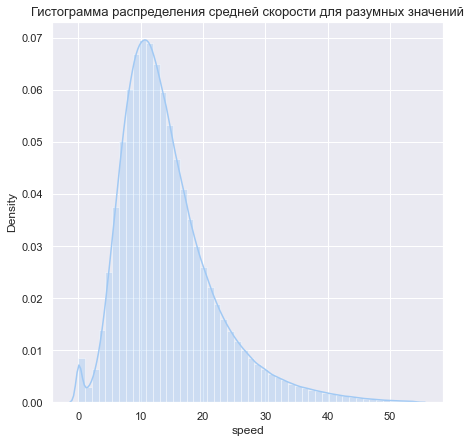

In [497]:
sns.distplot((data[data['speed'] <= data['speed'].quantile(0.999)])['speed']).set_title('Гистограмма распределения средней скорости для разумных значений', fontsize=13)

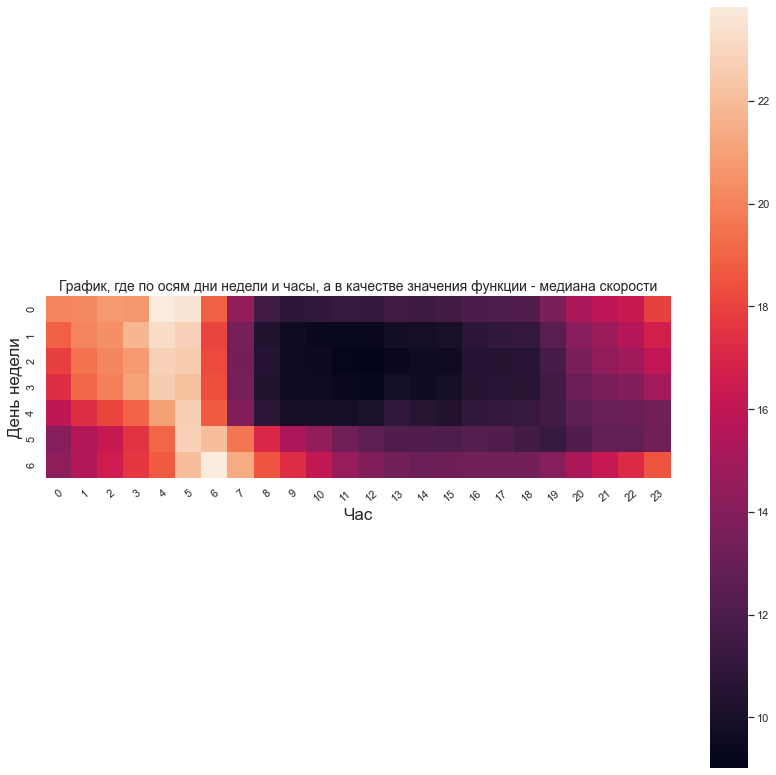

In [578]:
piv = pd.pivot_table(data.groupby(by=['day_of_week', 'hour']).median(), columns=["hour"], values=["speed"],index=["day_of_week"])

ax = sns.heatmap(piv, square=True)
ax.set_xticklabels(sorted(data['hour'].unique()), rotation=40)
plt.xlabel("Час", fontsize=17)
plt.title("График, где по осям дни недели и часы, а в качестве значения функции - медиана скорости", fontsize=14)
plt.ylabel("День недели", fontsize=17)
plt.rcParams['figure.figsize'] = 14, 14
plt.show()

In [579]:
print('Корреляция скорости с нашим таргетом:')
print(data['log_trip_duration'].corr(data['speed']))

Корреляция скорости с нашим таргетом:
-0.01981226526837094


Корреляция очень мала. Это получается в силу формулы для получения средней скорости:

data['haversine'] / ((np.exp(data['log_trip_duration']) - 1) / 3600)

In [580]:
data = data.drop(columns=['speed'])

In [581]:
data['free_road'] = data.shape[0] * [0]
data['traffic_jams'] = data.shape[0] * [0]
data.loc[list((data[(data['hour'] <= 5) & (data['hour'] >=1)]).index), 'free_road'] = 1
data.loc[list((data[(data['hour'] <= 10) & (data['hour'] >=7) & 
                    ((data['day_of_week'] == 6) | (data['day_of_week'] == 5))]).index), 'free_road'] = 1



data.loc[list((data[(data['hour'] <= 17) & (data['hour'] >=8) & 
                    ((data['day_of_week'] != 6) & (data['day_of_week'] != 5))]).index), 'traffic_jams'] = 1

data.loc[list((data[(data['hour'] <= 15) & (data['hour'] >=14) & 
                    ((data['day_of_week'] == 6) & (data['day_of_week'] == 5))]).index), 'traffic_jams'] = 1



In [582]:
data['start_in_first_special'] = data.shape[0] * [0]
data['stop_in_first_special'] = data.shape[0] * [0]
data['start_in_second_special'] = data.shape[0] * [0]
data['stop_in_second_special'] = data.shape[0] * [0]
data.loc[list((data[(data['pickup_latitude'] <= 40.783385) & (data['pickup_latitude'] >= 40.766881) & (data['pickup_longitude'] >= -73.890025) & (data['pickup_longitude'] <= -73.852794)]).index), 'start_in_first_special'] = 1
data.loc[list((data[(data['dropoff_latitude'] <= 40.783385) & (data['dropoff_latitude'] >= 40.766881) & (data['dropoff_longitude'] >= -73.890025) & (data['dropoff_longitude'] <= -73.852794)]).index), 'stop_in_first_special'] = 1
data.loc[list((data[(data['pickup_latitude'] <= 40.657026) & (data['pickup_latitude'] >= 40.626381) & (data['pickup_longitude'] >= -73.820924) & (data['pickup_longitude'] <= 73.751243)]).index), 'start_in_second_special'] = 1
data.loc[list((data[(data['dropoff_latitude'] <= 40.657026) & (data['dropoff_latitude'] >= 40.626381) & (data['dropoff_longitude'] >= -73.820924) & (data['dropoff_longitude'] <= 73.751243)]).index), 'stop_in_second_special'] = 1

Text(0.5, 1.0, 'Распределение логарифма времени поездки для периода пробок')

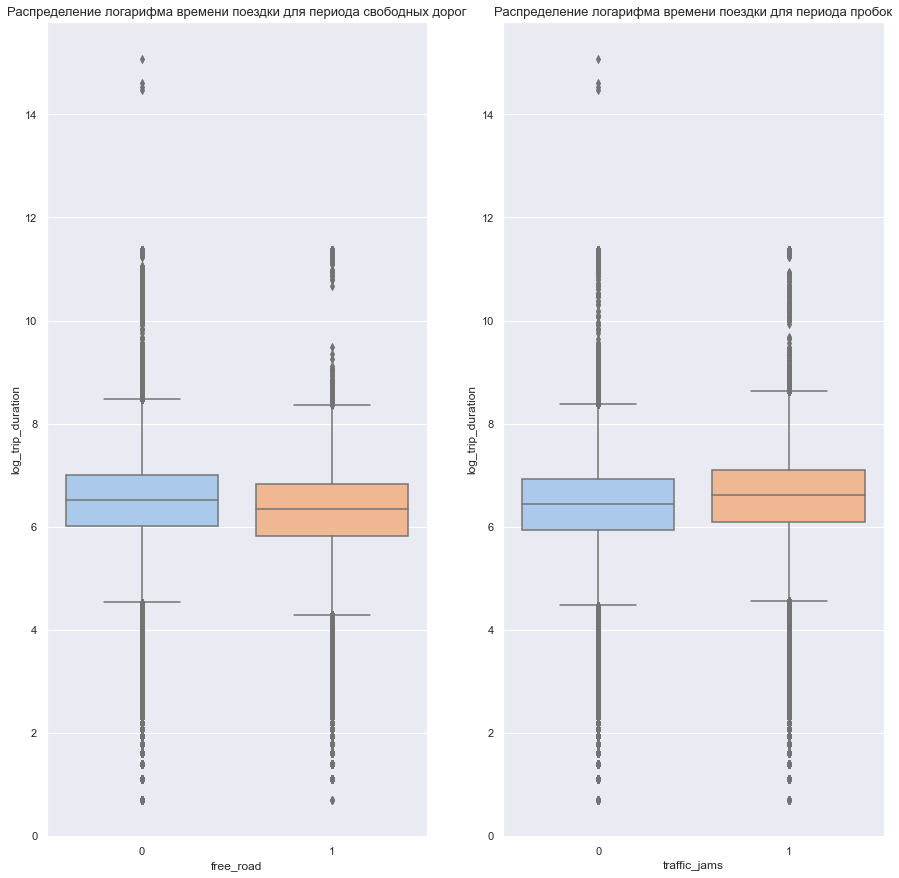

In [335]:
fig, ax =plt.subplots(1,2)
plt.rcParams['figure.figsize'] = 15, 15
sns.boxplot(x=data['free_road'], y=data['log_trip_duration'],ax=ax[0]).set_title('Распределение логарифма времени поездки для периода свободных дорог', fontsize=13)
sns.boxplot(x=data['traffic_jams'], y=data['log_trip_duration'],ax=ax[1]).set_title('Распределение логарифма времени поездки для периода пробок', fontsize=13)

Text(0.5, 1.0, 'Распределение логарифма времени для завершения в 1 выделющейся точке')

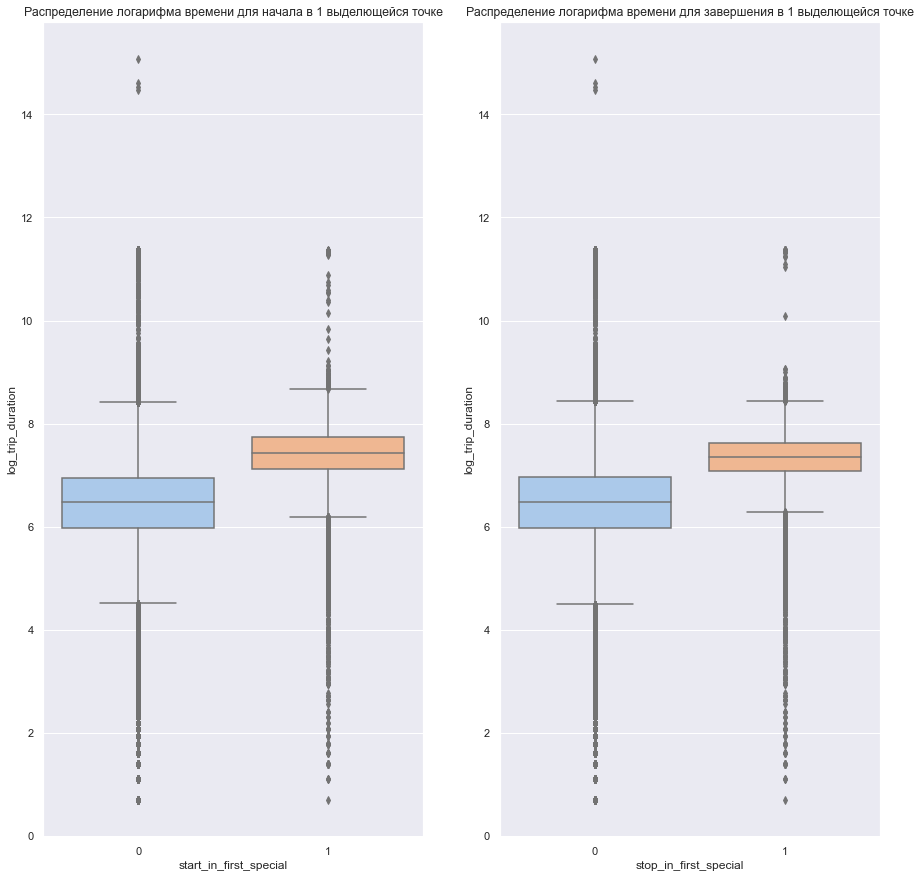

In [505]:
fig, ax =plt.subplots(1,2)
plt.rcParams['figure.figsize'] = 15, 15
sns.boxplot(x=data['start_in_first_special'], y=data['log_trip_duration'],ax=ax[0]).set_title('Распределение логарифма времени для начала в 1 выделющейся точке', fontsize=12.3)
sns.boxplot(x=data['stop_in_first_special'], y=data['log_trip_duration'],ax=ax[1]).set_title('Распределение логарифма времени для завершения в 1 выделющейся точке', fontsize=12.3)

Text(0.5, 1.0, 'Распределение логарифма времени для завершения во 2 выделющейся точке')

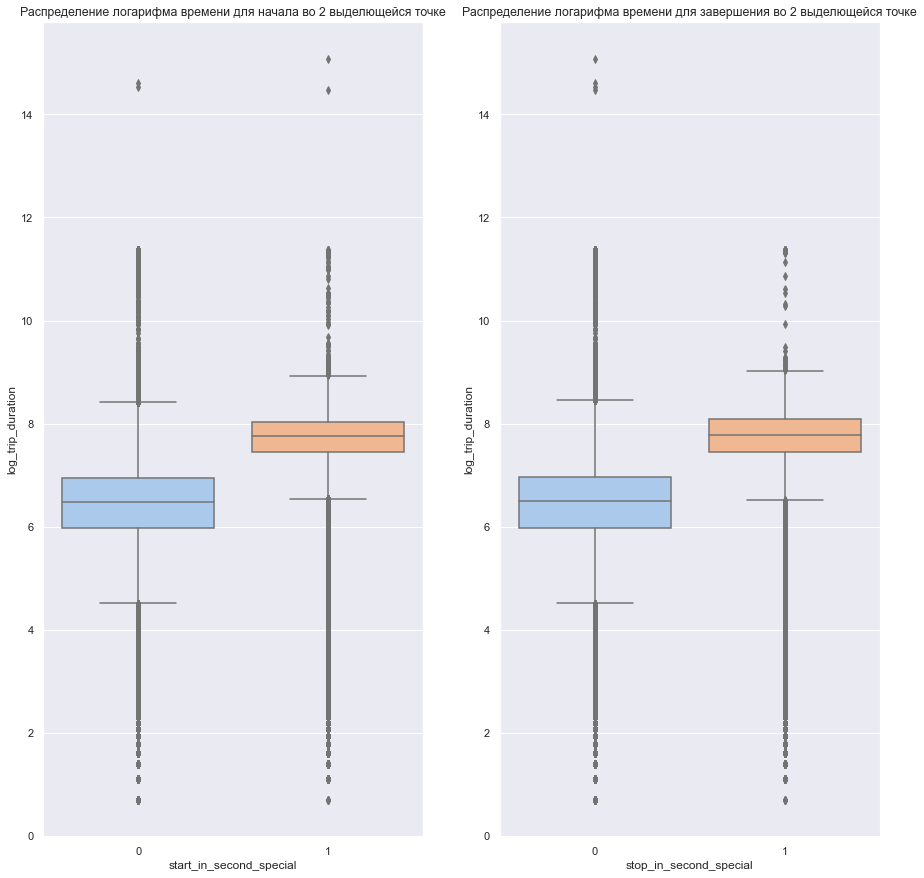

In [506]:
fig, ax =plt.subplots(1,2)
plt.rcParams['figure.figsize'] = 15, 15
sns.boxplot(x=data['start_in_second_special'], y=data['log_trip_duration'],ax=ax[0]).set_title('Распределение логарифма времени для начала во 2 выделющейся точке', fontsize=12.3)
sns.boxplot(x=data['stop_in_second_special'], y=data['log_trip_duration'],ax=ax[1]).set_title('Распределение логарифма времени для завершения во 2 выделющейся точке', fontsize=12.3)

Судя по графикам признаки по насыщенности дорожного потока несильно, но все же будут эффективными. Признаки про выделяющиеся точки получились очень хорошими. Ведь явно поездка из или в аэропорт занимает больше времени, чем по городу.

In [583]:
from sklearn.base import BaseEstimator, TransformerMixin

class Lettransform(BaseEstimator, TransformerMixin):
    def __init__(self, latitude_down, longitude_left, latitude_up, longitude_right):
        step1 = (longitude_right - longitude_left) / 3
        self.long1 = longitude_left + step1
        self.long2 = self.long1 + step1
        step2 = (latitude_up - latitude_down) / 4
        self.lat1 = latitude_down + step2
        self.lat2 = self.lat1 + step2
        self.lat3 = self.lat2 + step2
        self.longitude_right = longitude_right
        self.longitude_left = longitude_left
        self.latitude_up = latitude_up
        self.latitude_down = latitude_down

    def transform(self, data1):
        data = data1.copy()
        data['pickup_zone'] = data.shape[0] * [-1]
        data['dropoff_zone'] = data.shape[0] * [-1]
        longitudelist = [self.longitude_left, self.long1, self.long2, self.longitude_right]
        latitudelist = [self.latitude_down, self.lat1, self.lat2, self.lat3, self.latitude_up]
        zone = 1
        for i in range(3):
            for j in range(4):
                data.loc[list((data[(data['pickup_latitude'] <= latitudelist[j + 1]) 
                            & (data['pickup_latitude'] >= latitudelist[j]) 
                            & (data['pickup_longitude'] >= longitudelist[i]) 
                            & (data['pickup_longitude'] <= longitudelist[i + 1])]).index), 'pickup_zone'] = zone
                zone += 1
        zone = 1
        for i in range(3):
            for j in range(4):
                data.loc[list((data[(data['dropoff_latitude'] <= latitudelist[j + 1]) 
                            & (data['dropoff_latitude'] >= latitudelist[j]) 
                            & (data['dropoff_longitude'] >= longitudelist[i]) 
                            & (data['dropoff_longitude'] <= longitudelist[i + 1])]).index), 'dropoff_zone'] = zone
                zone += 1
            
        return data
         

In [584]:
data = Lettransform(40.691458, -74.031031, 40.814169, -73.931803).transform(data)

In [585]:
from sklearn.model_selection import train_test_split
y = data["log_trip_duration"]
X = data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)
categorical1 += ['pickup_zone', 'dropoff_zone']
numeric_features += ['start_in_first_special','free_road', 'traffic_jams', 'stop_in_first_special', 'start_in_second_special', 'stop_in_second_special', 'log_haversine']
categorical1 = list(set(categorical1))
numeric_features = list(set(numeric_features))
feat = numeric_features + categorical1

In [586]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model = pipeline.fit(X_train[feat], y_train)
y_pred = model.predict(X_test[feat])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4714


`vendor_id`: Для разных поставщиков услуг могут быть получены разные данные.

`passenger_count`: При большом количестве пассажиров автомобиль может ехать не так быстро, и  длительность поздки в компании может быть больше


In [587]:
print('vendor_id:')
print('Уникальных значений')
print(data['vendor_id'].nunique())
display(data['vendor_id'].value_counts().to_frame())
print('passenger_count:')
print('Уникальных значений')
print(data['passenger_count'].nunique())
display(data['passenger_count'].value_counts().to_frame())
print('store_and_fwd_flag:')
print('Уникальных значений')
print(data['store_and_fwd_flag'].nunique())
display(data['store_and_fwd_flag'].value_counts().to_frame())

vendor_id:
Уникальных значений
2


,vendor_id
2,780302
1,678342


passenger_count:
Уникальных значений
10


,passenger_count
1,1033540
2,210318
5,78088
3,59896
6,48333
4,28404
0,60
7,3
8,1
9,1


store_and_fwd_flag:
Уникальных значений
2


,store_and_fwd_flag
N,1450599
Y,8045


[Text(0.5, 1.0, 'Распределение логарифма времени поездки в зависимости от store_and_fwd_flag')]

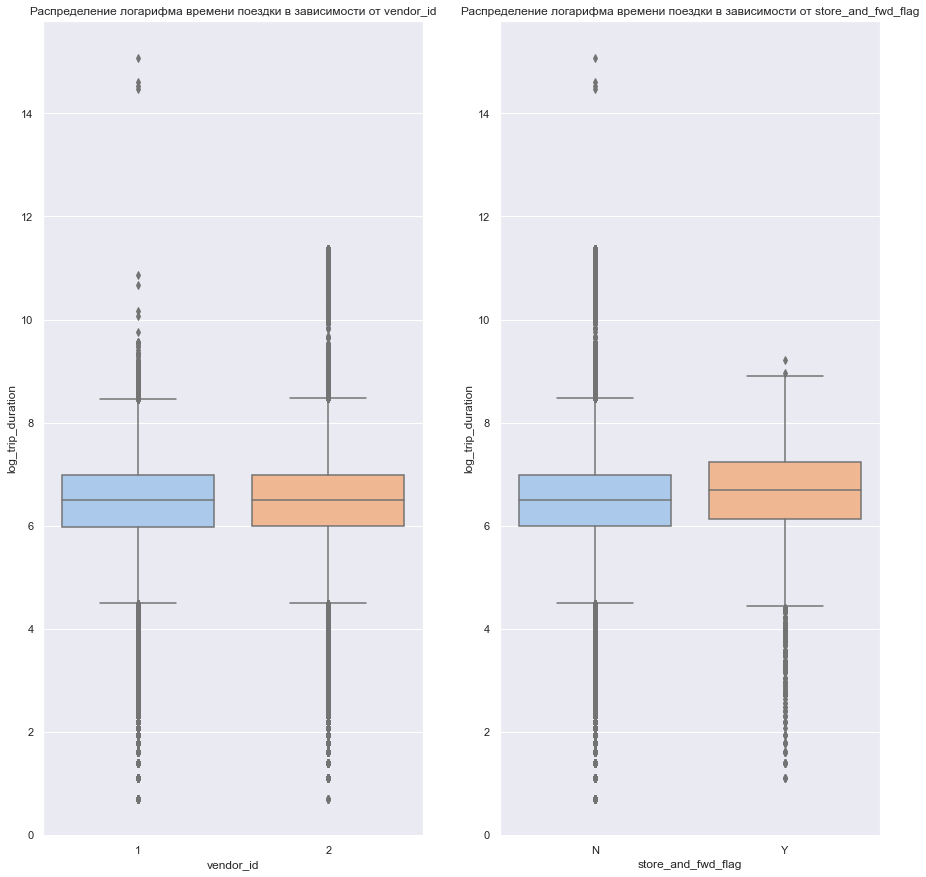

In [343]:
fig, ax =plt.subplots(1,2)
plt.rcParams['figure.figsize'] = 15, 15
sns.boxplot(x=data['vendor_id'], y=data['log_trip_duration'],ax=ax[0]).set_title('Распределение логарифма времени поездки в зависимости от vendor_id', fontsize=12)
sns.boxplot(x=data['store_and_fwd_flag'], y=data['log_trip_duration'],ax=ax[1]).set(title='Распределение логарифма времени поездки в зависимости от store_and_fwd_flag')

Text(0.5, 1.0, 'Ящик с усами распределений логарифма времени поездки в зависимости от количества пассажиров')

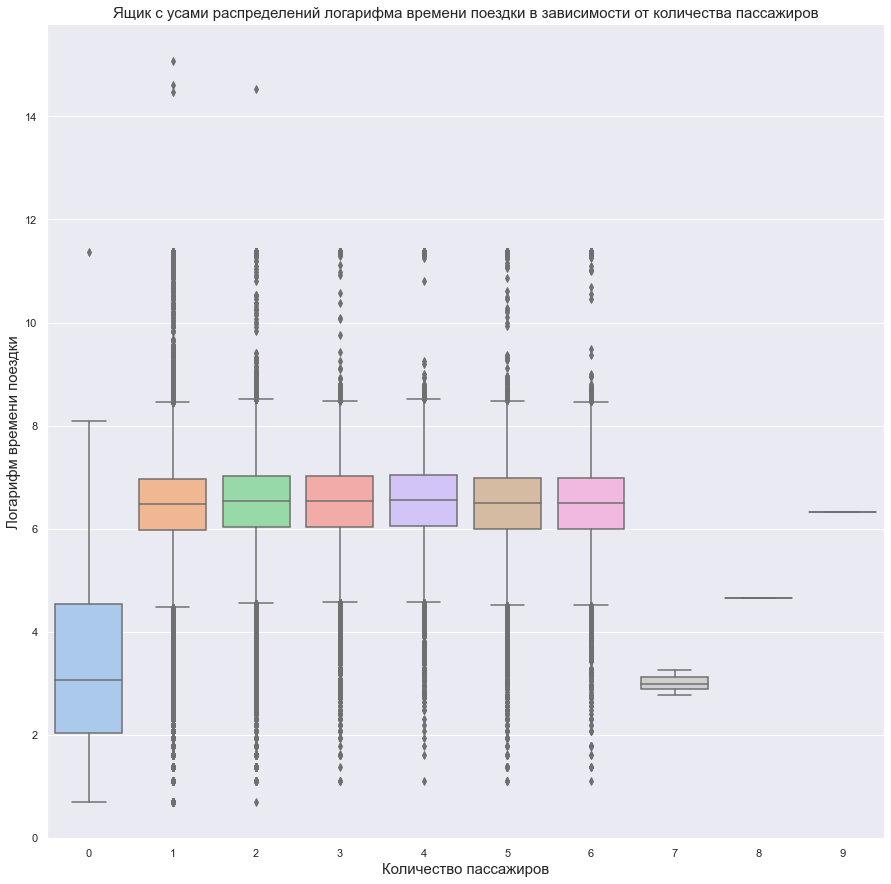

In [513]:
sns.boxplot(x=data['passenger_count'], y=data['log_trip_duration'])
plt.ylabel("Логарифм времени поездки", fontsize=15)
plt.xlabel("Количество пассажиров", fontsize=15)
plt.title("Ящик с усами распределений логарифма времени поездки в зависимости от количества пассажиров", fontsize=15)

In [589]:
data['vendor_id'] -=1

In [590]:
data.loc[list(data[data['store_and_fwd_flag'] == 'N'].index), 'store_and_fwd_flag'] = 1
data.loc[list(data[data['store_and_fwd_flag'] == 'Y'].index), 'store_and_fwd_flag'] = 0


Данные признаки не будут сильными.


Признак `store_and_fwd_flag` не очень сильный, но небесполезный.

`vendor_id` Очень слабый признак, безполезный.

`passenger_count` Сильнее предыдущих, но также не очень сильный.

In [593]:
from sklearn.model_selection import train_test_split
y = data["log_trip_duration"]
X = data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

In [594]:
numeric_features += ['vendor_id','passenger_count', "store_and_fwd_flag"]
numeric_features = list(set(numeric_features))
feat = numeric_features + categorical1

In [595]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model = pipeline.fit(X_train[feat], y_train)
y_pred = model.predict(X_test[feat])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4712


C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


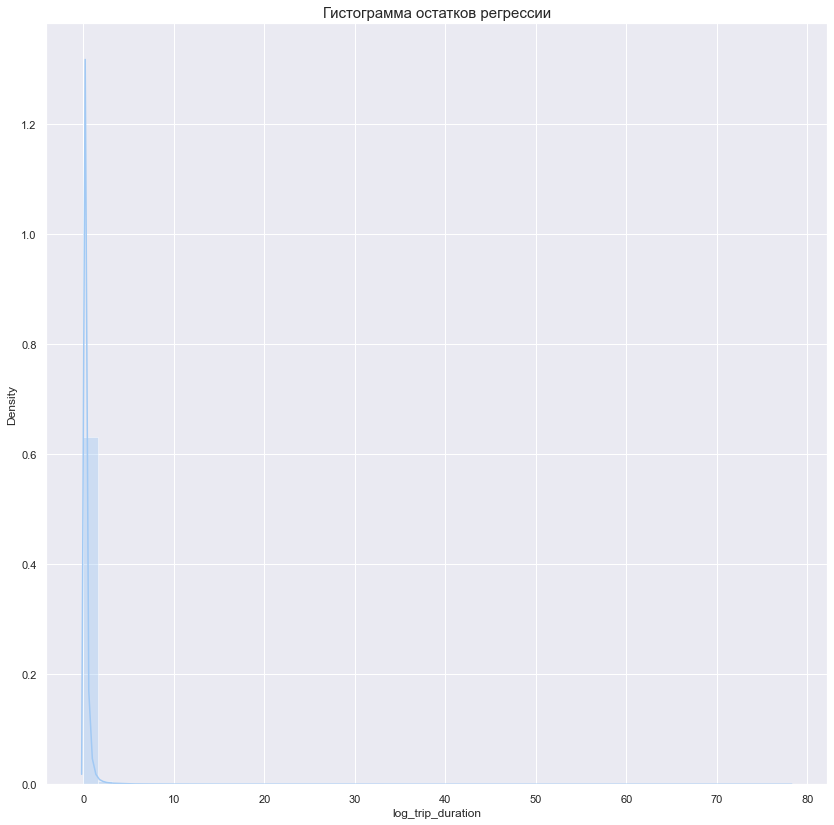

In [518]:
rest = (y_train - model.predict(X_train[feat])) ** 2
sns.distplot(rest)
plt.title("Гистограмма остатков регрессии", fontsize=15)
plt.show()

C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


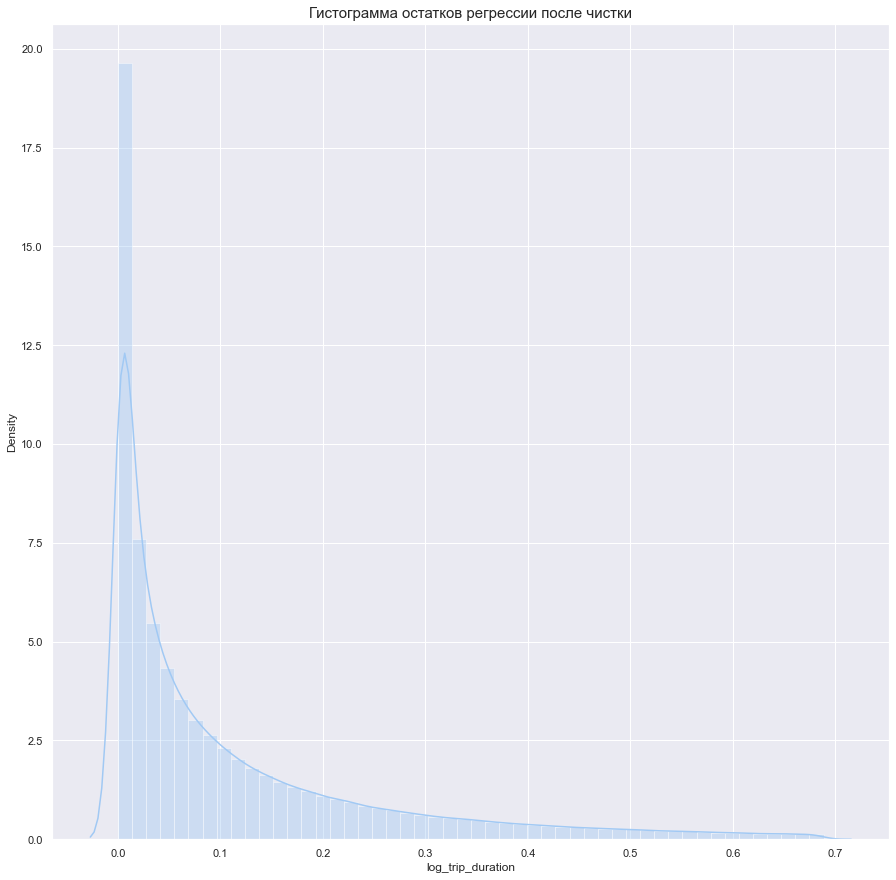

In [351]:
rest = (y_train - model.predict(X_train[feat])) ** 2
sns.distplot(rest[rest <= rest.quantile(0.95)])
plt.title("Гистограмма остатков регрессии после чистки", fontsize=15)
plt.show()

C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Распределение времени поездки до чистки'),
 Text(0.5, 0, 'Время поездки')]

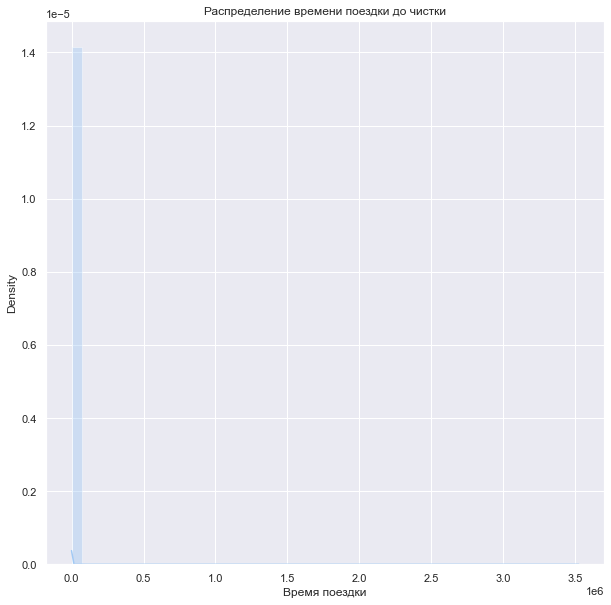

In [466]:
sns.distplot(np.exp(data['log_trip_duration']) - 1).set(title = 'Распределение времени поездки до чистки', xlabel='Время поездки')

C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Распределение времени поездки после чистки'),
 Text(0.5, 0, 'Время поездки')]

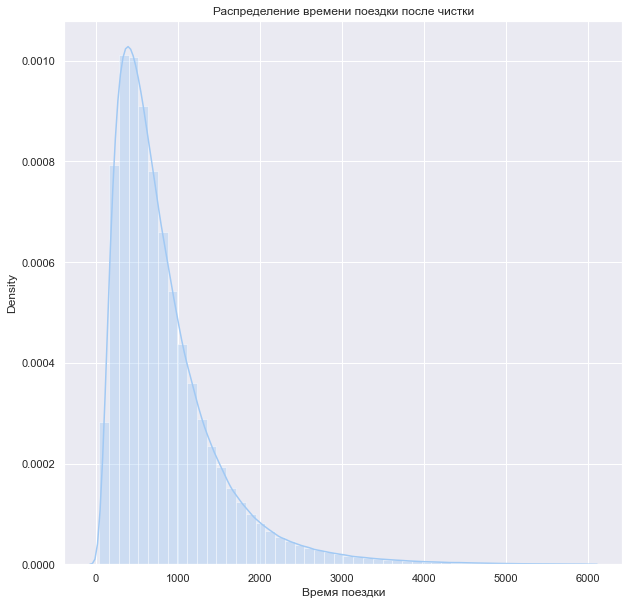

In [469]:
sns.distplot(np.exp(data[(data['log_trip_duration'] < np.log1p(6000)) & 
                         (data['log_trip_duration'] > np.log1p(40))]['log_trip_duration']) - 1).set(title = 'Распределение времени поездки после чистки', xlabel='Время поездки')

C:\Users\vladi\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


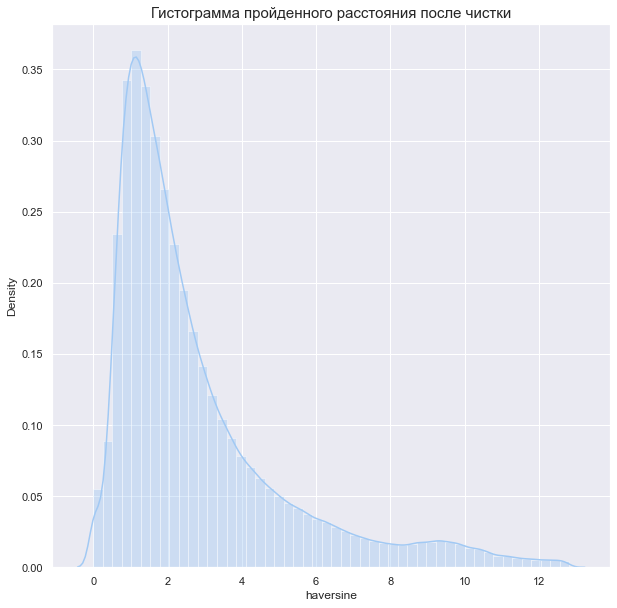

In [473]:
sns.distplot(data[data['haversine'] <= data['haversine'].quantile(0.96)]['haversine'])
plt.title("Гистограмма пройденного расстояния после чистки", fontsize=15)
plt.show()

In [596]:
def better(y_train, X_train):
    rest = (y_train - model.predict(X_train[feat])) ** 2
    X_train = X_train.loc[rest[rest <= rest.quantile(0.95)].index]
    X_train = X_train[(X_train['log_trip_duration'] < np.log1p(6000)) & 
                         (X_train['log_trip_duration'] > np.log1p(40))]
    X_train = X_train[X_train['haversine'] <= X_train['haversine'].quantile(0.96)]
    return X_train

In [597]:
X_train = better(y_train, X_train)

In [598]:
print(data['anomalous1'].value_counts())
print(data['anomalous2'].value_counts())

0    1456996
1       1648
Name: anomalous1, dtype: int64
0    1455261
1       3383
Name: anomalous2, dtype: int64


**Объединим аномальные даты в один бинарный признак:**

In [599]:
data['anomalous1'] += data['anomalous2']

In [600]:
data['dropoff_zone'].value_counts()

 7     373408
 6     353847
 11    177402
-1     149073
 2     116651
 1      76697
 12     66377
 8      60620
 5      41439
 9      16919
 3      15444
 10     10722
 4         45
Name: dropoff_zone, dtype: int64

**Объединим 3 и 4 зоны посадки и высадки, так как  4 зона - редкая категория**

In [601]:
data.loc[data[data['pickup_zone'] == 4].index, 'pickup_zone'] = 3

In [602]:
data.loc[data[data['dropoff_zone'] == 4].index, 'dropoff_zone'] = 3

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [603]:
numeric_features.remove('anomalous2')

In [604]:
feat.remove('anomalous2')

In [605]:
y_train = X_train['log_trip_duration']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model = pipeline.fit(X_train[feat], y_train)
y_pred = model.predict(X_test[feat])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4726


In [606]:
print("Количество признаков до кодирования:", data[feat].shape[1])
print("Количество признаков после кодирования:", column_transformer.transform(X_train[feat]).shape[1])

Количество признаков до кодирования: 17
Количество признаков после кодирования: 256


In [607]:
from sklearn.linear_model import Lasso
y_train = X_train['log_trip_duration']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
    ('scaling', StandardScaler(), numeric_features)
])
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])
model = lasso_pipeline.fit(X_train[feat], y_train)
y_pred = model.predict(X_test[feat])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7947


Ridge получилась намного лучше.

In [436]:
y = X_train["log_trip_duration"]
X = X_train

X_train1, X_val, y_train1, y_val = train_test_split(
    X, y, test_size=0.2, random_state=10)

# Подберем оптимальный коэффицент регуляризации.

In [437]:
alphasridge = np.logspace(1, 3, 60)

In [618]:
ridge_zeros_list = []
ridge_min = 0.79434
for a in alphasridge:
    y_train1 = X_train1['log_trip_duration']
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
        ('scaling', StandardScaler(), numeric_features)
    ])
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Ridge(alpha = a))
    ])
    
    model = pipeline.fit(X_train1[feat], y_train1)
    y_pred = model.predict(X_val[feat])
    if (mean_squared_error(y_val, y_pred, squared=False) < ridge_min):
        ridge_min = mean_squared_error(y_val, y_pred, squared=False)
        alpha_ridge = a
        bestridge_model = model
print('Ridge:')
print("Val RMSE для валидационной выборки при оптимальном значении параметра регуляризации = ", ridge_min)
print('alpha при оптимальном значении параметра регуляризации = ', alpha_ridge)

Ridge:
Val RMSE для валидационной выборки при оптимальном значении параметра регуляризации =  0.32571158790932536
alpha при оптимальном значении параметра регуляризации =  21.826447283974872


In [619]:
y_pred = bestridge_model.predict(X_test[feat])
print("RMSE на тестовой выборке лучшей полученной Ridge модели = %.6f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE на тестовой выборке лучшей полученной Ridge модели = 0.466073


In [459]:
alphaslasso = np.logspace(-3, -2, 15)

In [448]:
lasso_min = 0.79434
lasso_zeros_list = []
for a in alphaslasso:
    y_train1 = X_train1['log_trip_duration']
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
        ('scaling', StandardScaler(), numeric_features)
    ])
    pipeline_lasso = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(alpha = a))
    ])
    lassomodel = pipeline_lasso.fit(X_train1[feat], y_train1)
    y_pred_lasso = lassomodel.predict(X_val[feat])
    lasso_zeros = np.sum(pipeline_lasso.steps[-1][-1].coef_ == 0)
    lasso_zeros_list.append(lasso_zeros)
    y_pred = lassomodel.predict(X_test[feat])
    print("Нулевые веса в Lasso:", lasso_zeros)
    print(mean_squared_error(y_test, y_pred, squared=False))
    if (mean_squared_error(y_val, y_pred_lasso, squared=False) < lasso_min):
        lasso_min = mean_squared_error(y_val, y_pred_lasso, squared=False)
        alpha_lasso = a
        best_lasso_model = lassomodel
print('Lasso:')
print("Val RMSE для валидационной выборки при оптимальном значении параметра регуляризации = ", lasso_min)
print('alpha при оптимальном значении параметра регуляризации= ', alpha_lasso)

Нулевые веса в Lasso: 88
0.47336533856095364
Нулевые веса в Lasso: 115
0.4735172765597659
Нулевые веса в Lasso: 141
0.473734617083038
Нулевые веса в Lasso: 163
0.4740211871151899
Нулевые веса в Lasso: 176
0.47441447614273513
Нулевые веса в Lasso: 188
0.4748931716794184
Нулевые веса в Lasso: 195
0.4755338517943411
Нулевые веса в Lasso: 202
0.47625604194032367
Нулевые веса в Lasso: 209
0.4769895991487117
Нулевые веса в Lasso: 216
0.4779400616148125
Нулевые веса в Lasso: 219
0.4794482162298617
Нулевые веса в Lasso: 223
0.48183872111471854
Нулевые веса в Lasso: 230
0.48564725178545864
Нулевые веса в Lasso: 238
0.49046460802179886
Нулевые веса в Lasso: 243
0.4953259973113793
Lasso:
Val RMSE для валидационной выборки при оптимальном значении параметра регуляризации =  0.3333373894902861
alpha при оптимальном значении параметра регуляризации=  0.0001


In [449]:
y_pred = best_lasso_model.predict(X_test[feat])
print("RMSE на тестовой выборке лучшей полученной Lasso модели = %.6f" % mean_squared_error(y_test, y_pred, squared=False))

RMSE на тестовой выборке лучшей полученной Lasso модели = 0.473365


При потере примерно половины признаков на тестовой выборке мы получаем RMSE = 0.4735172, теряем очень мало в качестве.

Можно найти намного лучшее альфа, оно будет меньше, чем найденное, стремящиеся к 0. Будет обнуляться намного меньше признаков, но обучение происходит очень долго и затратно(.

Text(0.5, 1.0, 'График зависимости количества нулевых весов в модели от alpha')

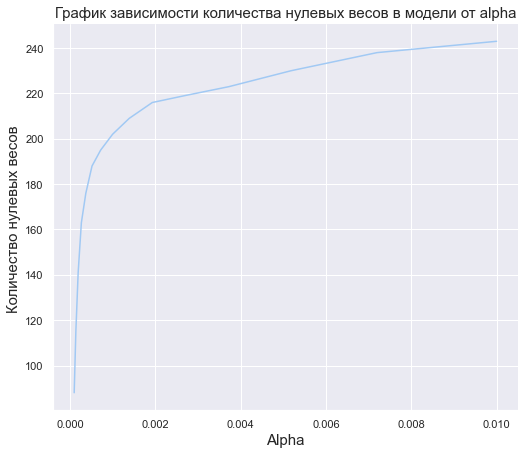

In [452]:
sns.relplot(x=alphaslasso, y=lasso_zeros_list,
            height=6, aspect = 1.2, kind='line')
plt.ylabel("Количество нулевых весов ", fontsize=15)
plt.xlabel("Alpha", fontsize=15)
plt.title("График зависимости количества нулевых весов в модели от alpha", fontsize=15)

**Продолжим рассматривать координаты:**

Регрессия не может связать два признака по зонам посадки и высадки, она рассматривает и подбирает веса для них по отдельности.

In [608]:
zone = data[(data['pickup_zone'] != -1) & (data['dropoff_zone'] != -1)].groupby(by=['pickup_zone', 'dropoff_zone']).size().reset_index(name='count').sort_values(by = 'count', ascending=False).reset_index().head(100)
zone['trip_zone'] = zone.shape[0] * [-1]
zone['trip_zone'] = zone.index.tolist()
zone = zone.drop(columns=['count'])
data2 = pd.merge(data, zone, on=['pickup_zone', 'dropoff_zone'], how='left')
data['trip_zone'] = data.shape[0] * [-1]
data['trip_zone'] = data2['trip_zone']

In [609]:
data.loc[data[data['trip_zone'].isnull()].index, 'trip_zone'] = -1

In [612]:
from sklearn.model_selection import train_test_split
y = data["log_trip_duration"]
X = data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

In [615]:
X_train = better(y_train, X_train)

In [616]:
categorical1 += ['trip_zone']
categorical1 = list(set(categorical1))
numeric_features = list(set(numeric_features))
feat = numeric_features + categorical1

In [617]:
y_train = X_train['log_trip_duration']
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical1),
    ('scaling', StandardScaler(), numeric_features)
])
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])
model = pipeline.fit(X_train[feat], y_train)
y_pred = model.predict(X_test[feat])
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4651


**Получили** модель линейной регрессии с RMSE = 0.4651